In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from pathlib import Path
import networkx as nx


from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

from visu_utils import *

# white grid
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:

METRIC = "I(X_1->X_2)/d_2"

PREFIX = "mteb_ds"
df = pd.read_csv('exported_data/normalized_13.df')

df = text_embeddings_metadata_results_preprocessing(df, models=ALL_BUT_RANDOM)

table = make_table_pivot(METRIC, df)

info = table.median(axis=1).to_frame(METRIC).reset_index().rename(columns={'model_1': 'model'})
display(info)



/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)


,model,I(X_1->X_2)/d_2
0,BAAI/bge-base-en-v1.5,0.571216
1,GritLM/GritLM-7B,0.593433
2,NousResearch/Llama-2-7b-hf,0.547375
3,Salesforce/SFR-Embedding-Mistral,0.623777
4,SmartComponents/bge-micro-v2,0.544457
5,TaylorAI/gte-tiny,0.554370
6,WhereIsAI/UAE-Large-V1,0.570720
7,avsolatorio/GIST-Embedding-v0,0.577252
8,croissantllm/CroissantCool,0.525260
9,croissantllm/CroissantLLMBase,0.524295


In [61]:
MTEB_PATH = "exported_data/mteb_detailed"

# load all the data

mteb_data = []

def extract_url_from_html_link(html):
    return re.findall(r'href=[\'"]?([^\'" >]+)', html)[0]

for path in Path(MTEB_PATH).rglob("*.csv"):
    _df = pd.read_csv(path)
    _df['model'] = _df['Model'].apply(extract_url_from_html_link).apply(lambda x: "/".join(x.split('/')[-2:]))
    # drop Model
    _df = _df.drop(columns = ['Model', 'Model Size (Million Parameters)',
       'Memory Usage (GB, fp32)', 'Rank'])
    # merge with info on model, keep only the ones that are in info 
    _df = _df.merge(info, on='model', how='inner')
    if len(_df) <= 10:
        continue
    _df = _df.set_index(['Subset', 'Task category', 'model'])
    mteb_data.append(_df)
    
    


In [62]:
NON_METRIC_COLUMNS = ['Subset', 'Task category', 'model', METRIC]
NON_METRIC_COLUMNS_BUT_METRIC = ['Subset', 'Task category', 'model']
AVERAGE = ['Average']

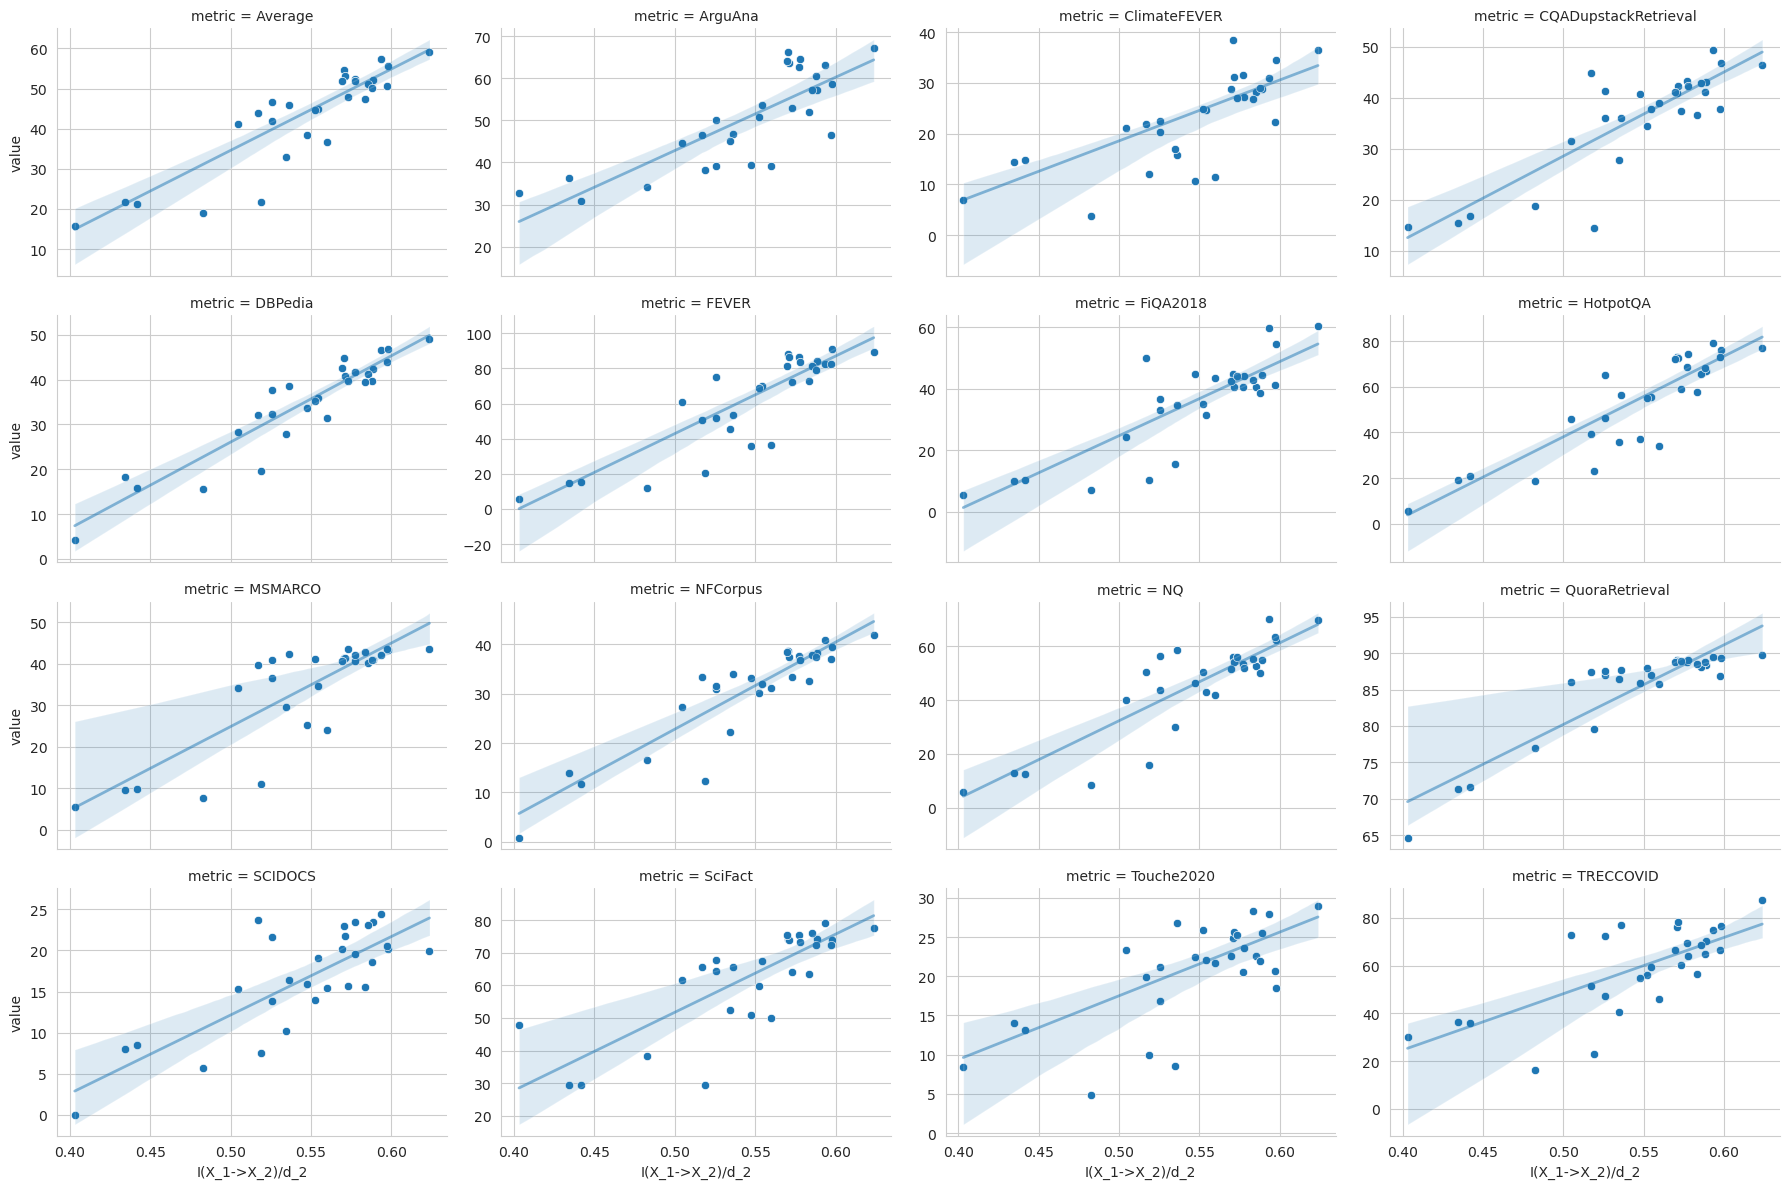

In [44]:



def plot_reg(x,y, **kwargs):
    ax = plt.gca()
    sns.regplot(x=x,y=y, ci=95, color=kwargs.get('color') , scatter=False, ax=ax, x_ci='sd', line_kws={'linewidth': 2, 'alpha' : 0.5}, truncate=True, label=kwargs.get('label'), robust=True)
    return ax


for _df in mteb_data:
    n_metrics = len(_df.columns) - 1
    melted = _df.reset_index().melt(id_vars=NON_METRIC_COLUMNS, var_name='metric', value_name='value')
    
    g = sns.relplot(data=melted, x=METRIC, y='value', col='metric', kind='scatter', col_wrap=4, facet_kws={'sharey': False}, height=3, aspect=1.5)
    g.map(plot_reg, METRIC, 'value')
    break
    
    
    


    

In [88]:
# Make big correlation table

all_mteb = pd.concat(mteb_data)
grouped = all_mteb.groupby(['Subset', 'Task category'])

pearson = grouped.corr(method='pearson')[METRIC].rename('$\\rho_p$').dropna()
spearman = grouped.corr(method='spearman')[METRIC].rename('$\\rho_s$').dropna()
kendall = grouped.corr(method='kendall')[METRIC].rename('$\\tau$').dropna()

# drop METRIC from all the rows
pearson = pearson.drop(METRIC, level=2)
spearman = spearman.drop(METRIC, level=2)
kendall = kendall.drop(METRIC, level=2)

_df = pd.concat([pearson, spearman, kendall], axis=1)

_df = _df.loc['en']

idx = pd.IndexSlice
#first_part = _df.loc[['Classification', 'Clustering', 'PairClassification', 'Reranking']]
# second_part = _df.loc[['Retrieval','STS', 'Summarization']]
first_part = _df



# Make first part of the table
style = first_part.style
style = style.format("{:.2f}")

style = style.apply(lambda x: [f"bfseries:" for xx in x], axis=1, subset=(idx[:, "Average"], idx[:]))
                   
style = style.apply_index(lambda x: [f"bfseries:" if xx == "Average" else "" for xx in x] , axis=0, level=1)

latex = style.to_latex(clines="skip-last;data", sparse_index=True, hrules=True)

path = Path(f"../../../papers/emir-embedding-comparison/tables/nlp/{PREFIX}_detailed_correlations_{sanitize_metric_name(METRIC)}_part_1.tex")
path.parent.mkdir(parents=True, exist_ok=True)
with open(path, 'w') as f:
    f.write(latex)

# # Make second part of the table
# style = second_part.style
# style = style.format("{:.2f}")
# 
# latex = style.to_latex(clines="skip-last;data", sparse_index=True, hrules=True)
# 
# path = Path(f"../../../papers/emir-embedding-comparison/tables/nlp/{PREFIX}_detailed_correlations_{sanitize_metric_name(METRIC)}_part_2.tex")
# path.parent.mkdir(parents=True, exist_ok=True)
# 
# with open(path, 'w') as f:
#     f.write(latex)






In [59]:
_df

,Average,ArguAna,ClimateFEVER,CQADupstackRetrieval,DBPedia,FEVER,FiQA2018,HotpotQA,MSMARCO,NFCorpus,NQ,QuoraRetrieval,SCIDOCS,SciFact,Touche2020,TRECCOVID,Subset,Task category,I(X_1->X_2)/d_2
model,,,,,,,,,,,,,,,,,,,
Salesforce/SFR-Embedding-Mistral,59.00,67.17,36.41,46.49,49.06,89.35,60.40,77.02,43.41,41.88,69.92,89.78,19.91,77.66,29.00,87.60,en,Retrieval,0.623777
GritLM/GritLM-7B,57.41,63.24,30.91,49.42,46.60,82.74,59.95,79.40,41.96,40.89,70.30,89.47,24.41,79.17,27.93,74.80,en,Retrieval,0.593433
jspringer/echo-mistral-7b-instruct-lasttoken,55.52,58.52,34.56,46.91,46.83,91.22,54.51,76.41,43.25,39.55,62.31,89.34,20.17,73.99,18.52,76.66,en,Retrieval,0.597901
WhereIsAI/UAE-Large-V1,54.66,66.15,38.53,40.93,44.89,88.24,44.84,73.13,41.40,38.65,55.86,89.02,22.98,74.07,24.93,76.33,en,Retrieval,0.570720
BAAI/bge-base-en-v1.5,53.25,63.61,31.17,42.35,40.77,86.29,40.65,72.60,41.35,37.39,54.15,88.90,21.73,74.04,25.70,78.07,en,Retrieval,0.571216
avsolatorio/GIST-Embedding-v0,52.31,62.62,31.49,43.20,41.70,86.65,40.64,68.92,40.64,37.64,53.43,88.81,23.47,75.29,20.58,69.60,en,Retrieval,0.577252
thenlper/gte-large,52.22,57.16,28.82,43.18,42.37,84.53,44.50,67.16,40.86,38.17,54.78,88.32,23.44,74.27,25.51,70.22,en,Retrieval,0.588731
llmrails/ember-v1,51.92,64.56,27.29,42.39,41.79,83.69,44.30,74.33,42.03,36.91,51.77,89.09,19.58,73.42,23.54,64.14,en,Retrieval,0.577596
jamesgpt1/sf_model_e5,51.80,64.07,28.74,41.14,42.51,81.38,42.64,72.37,40.66,38.43,51.55,88.74,20.16,75.41,22.60,66.57,en,Retrieval,0.569576
